In [1]:
import os, 
print(os.getcwd())

import numpy as np
import importlib
import three_cart.simulator as sim
np.set_printoptions(precision=3, suppress=True)
import matplotlib.pyplot as plt
import torch 
from torch.autograd import Variable
import torch.optim as optim
torch.set_printoptions(precision=3, sci_mode=False)
%precision 3

/home/hsuh/soft_contact


ImportError: No module named three_cart.simulator

In [3]:
importlib.reload(sim)

AttributeError: 'module' object has no attribute 'reload'

# Predefined inputs

In [812]:
def simulate(simulator, init_state, inputs):
    # recorder trajectories
    timesteps = inputs.shape[1]
    x_trajectory = np.zeros((6, timesteps))
    x_trajectory[:,0] = init_state
    lambda_trajectory = np.zeros((2, timesteps))
    # forward simulate
    simulator.set_state(init_state)
    for t in range(inputs.shape[1]):
        simulator.step(inputs[:, t]) # Control input
        x_trajectory[:,t] = simulator.get_state()
        lambda_trajectory[:,t] = simulator.get_contact()
    return x_trajectory, lambda_trajectory

In [811]:
# hyper params set 1
timesteps = 10000
init_state = np.array([100, 0, 300, 0, 400, 0]).astype(np.double)
inputs = np.array([[5, -5] for i in range(timesteps)]).T
params = {'m': 1.,  # mass
          'c': 3.0,  # viscosity
          'k': 10.0,  # elasticity
          'd': 80,    # cart length
          'w': 50,    # cart height (just for visualization) 
          'h': 0.01,   # time step
          't': 0.0}   # sleep time before redrawing on canvas

In [1022]:
# hyper params set 2
timesteps = 50
init_state = np.array([100, 0, 280, 0, 400, 0]).astype(np.double)
inputs = np.array([[50, -50] for i in range(timesteps)]).T
params = {'m': 1.,  # mass
          'c': 3.0,  # viscosity
          'k': 10.0,  # elasticity
          'd': 100,    # cart length
          'w': 200,    # cart height (just for visualization) 
          'h': 0.1,   # time step
          't': 0.05}   # sleep time before redrawing on canvas

In [1075]:
# hyper params set 3
timesteps = 50
init_state = np.array([100, 0, 300, 0, 400, 0]).astype(np.double)
inputs = np.array([[40, -40] for i in range(timesteps)]).T
params = {'m': 1.,  # mass
          'c': 2,  # viscosity
          'k': 10.0,  # elasticity
          'd': 80,    # cart length
          'w': 50,    # cart height (just for visualization) 
          'h': 0.1,   # time step
          't': 0.05}   # sleep time before redrawing on canvas

## Simulate

In [1093]:
try:
    C.tk.destroy()
except:
    pass
C = sim.CartSimulator(gui=True, video=True)
for key, value in params.items():
    C.set_parameters(key, value)
x_trajectory, lambda_trajectory = simulate(C, init_state, inputs)

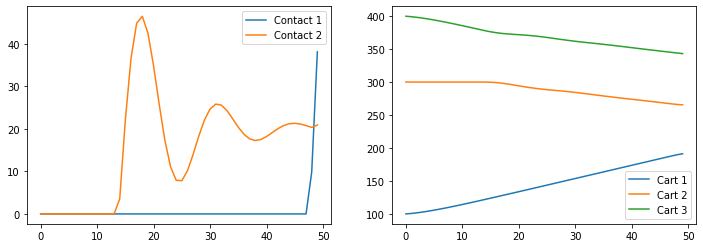

In [1077]:
# plotting
fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(1,2,1)
ax.plot(range(timesteps), lambda_trajectory[0,:])
ax.plot(range(timesteps), lambda_trajectory[1,:])
ax.legend(['Contact 1', 'Contact 2'])
ax = fig.add_subplot(1,2,2)
ax.plot(range(timesteps), x_trajectory[0,:])
ax.plot(range(timesteps), x_trajectory[2,:])
ax.plot(range(timesteps), x_trajectory[4,:])
ax.legend(['Cart 1', 'Cart 2', 'Cart 3'])

In [1078]:
goal_state = C.get_state()
goal_state

array([191.442,  15.404, 265.528,  -5.66 , 343.03 ,  -9.744])

In [1079]:
C.tk.destroy()

# Single Shooting to find inputs

In [743]:
# tensorized version of cart simulator class
class CartSimTensorized(sim.CartSimulator):
    def __init__(self, timesteps):
        super(CartSimTensorized, self).__init__(gui=False, video=False)
        self.timesteps = timesteps
        self.goal_state = torch.zeros(6).double()
        self.states = torch.zeros(6, self.timesteps+1).double()
        self.forces = torch.zeros(2, self.timesteps).double()

    def set_states(self, state, t):
        assert len(state) == 6
        self.states[:, t] = torch.tensor(state).double() #automatically creates a copy

    # Semi-implicit time-stepping for dynamics integration
    def forward_pass(self, inputs):
        # forward integrate to obtain a target state
        for t in range(self.timesteps):
            # Compute contact forces first
            lambda1 = torch.nn.ReLU()(-self.params['k'] * (self.states[2,t] - self.states[0,t] - self.params['d']))
            lambda2 = torch.nn.ReLU()(-self.params['k'] * (self.states[4,t] - self.states[2,t] - self.params['d']))
            self.forces[:,t] = torch.stack([lambda1, lambda2]).double().detach()

            # Propagate velocities ### EXAMINE HERE IF LAMBDA1 CAN BE USED
            self.states[1,t+1] = self.states[1,t] + self.params['h'] * \
                                (-self.params['c'] * self.states[1,t] - lambda1 + inputs[0,t])
            self.states[3,t+1] = self.states[3,t] + self.params['h'] * \
                                (-self.params['c'] * self.states[3,t] + lambda1 - lambda2)
            self.states[5,t+1] = self.states[5,t] + self.params['h'] * \
                                (-self.params['c'] * self.states[5,t] + lambda2 + inputs[1,t])

            # Propagate positions at t with velocities at t+1
            self.states[[0,2,4],t+1] = self.states[[0,2,4],t] + self.params['h'] * self.states[[1,3,5],t+1]
            
        return self.states[:, -1] 

## Update params to make optimization horizon shorter

In [1080]:
# obtain goal states from simulation with predefined inputs
print(goal_state)
print(init_state)
goal_state = torch.tensor(goal_state)
CSGD.set_states(init_state, 0)

[191.442  15.404 265.528  -5.66  343.03   -9.744]
[100.   0. 300.   0. 400.   0.]


In [1087]:
# inputs candidate 1 

# for hyper params set 1 - 10000 timesteps (not working)
# guess_inputs = np.array([[20, -20] for i in range(timesteps)]).T

# for hyper params set 2 - 100 timesteps
guess_inputs = np.array([[0, 0] for i in range(timesteps)]).T

In [1048]:
# inputs candidate 2

# for hyper params set 1 - 100 timesteps (not working)
# guess_inputs = np.random.uniform(-1, 1, (2, timesteps))

# for hyper params set 2 - 100 timesteps
guess_inputs = np.random.uniform(-100, 100, (2, timesteps))

In [1088]:
# for timesteps ~ 50, choose lr as large as 10, epochs ~ 100
# for timesteps > 50 doesn't quite work
lr = 10
epochs = 100
input_loss_weight = 0.0005
guess_inputs = torch.tensor(guess_inputs, requires_grad=True, dtype=torch.double)
optimizer = optim.SGD([guess_inputs], lr=lr)
losses = np.zeros(epochs)
for epoch in range(epochs):
    CSGD = CartSimTensorized(timesteps)
    CSGD.set_states(init_state, 0)
    final_state = CSGD.forward_pass(guess_inputs)
    # terminal loss
    terminal_loss = ((final_state - goal_state)**2).mean()
    # input L2 regulation
    input_loss = torch.sum(guess_inputs * guess_inputs)
    # total loss
    loss = terminal_loss + input_loss_weight*input_loss
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    losses[epoch] = loss.data.numpy()
    if True :
        print('{:.3f}'.format(loss.data.numpy()))
    

2193.308
1588.244
1191.600
914.460
719.185
580.330
480.626
408.301
355.282
316.005
286.605
270.869
265.082
260.561
256.759
253.535
250.778
248.398
246.327
244.508
242.896
241.457
240.162
238.988
237.917
236.933
236.024
235.181
234.395
233.660
232.969
232.319
231.742
231.571
230.780
230.547
229.944
229.609
229.179
228.750
228.478
227.959
227.831
227.229
227.234
226.659
226.409
226.170
225.939
225.716
225.500
225.291
225.090
224.895
224.706
224.524
224.347
224.176
224.011
223.852
223.697
223.547
223.403
223.263
223.127
222.996
222.870
222.747
222.628
222.513
222.402
222.295
222.191
222.090
221.992
221.898
221.807
221.718
221.633
221.550
221.470
221.392
221.317
221.245
221.174
221.106
221.041
220.977
220.915
220.855
220.798
220.742
220.687
220.635
220.584
220.535
220.488
220.442
220.397
220.354


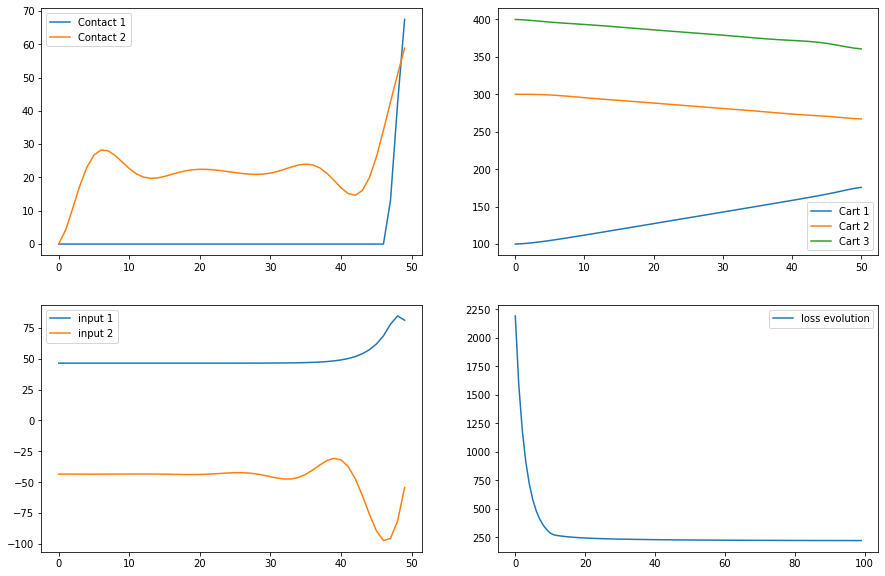

In [1101]:
plt.figure(figsize=(15, 10))
plt.subplot(2,2,1)
plt.plot(range(timesteps), CSGD.forces[0,:])
plt.plot(range(timesteps), CSGD.forces[1,:])
plt.legend(['Contact 1', 'Contact 2'])
plt.subplot(2,2,2)
plt.plot(range(timesteps+1), CSGD.states[0,:].detach())
plt.plot(range(timesteps+1), CSGD.states[2,:].detach())
plt.plot(range(timesteps+1), CSGD.states[4,:].detach())
plt.legend(['Cart 1', 'Cart 2', 'Cart 3'])
plt.subplot(2,2,3)
plt.plot(range(timesteps), guess_inputs[0,:].detach())
plt.plot(range(timesteps), guess_inputs[1,:].detach())
plt.legend(['input 1', 'input 2'])
plt.subplot(2,2,4)
plt.plot(range(epochs), losses)
plt.legend(['loss evolution'])
plt.show()

In [1117]:
try:
    C.tk.destroy()
except:
    pass
C = sim.CartSimulator(gui=True, video=True)
for key, value in params.items():
    C.set_parameters(key, value)
x_trajectory, lambda_trajectory = simulate(C, init_state, guess_inputs)

In [1118]:
C.tk.destroy()